# Getting started with the [AHEAD](https://dataverse.nl/dataset.xhtml?persistentId=doi:10.34894/IHZGQM) dataset.

Note: Please be patient at times when running the code. Depending on your machine, it can take ~1 hour to run everything on this notebook.

### The data in the AHEAD dataset are scanned using the MP2RAGEME sequence for T1, T2* and Quantitative Susceptibility Mapping in one sequence at 7 Tesla. Data are motion-corrected using Fat navigators (FatNavs), and defaced in image-domain.

### Use the link to download the dataset. The dataset is in the [ISMRMRD](https://ismrmrd.github.io/) format. We will use the [ismrmrd-python-tools](https://github.com/ismrmrd/ismrmrd-python-tools) to read the raw data.

In [1]:
! pip install ismrmrd

In [2]:
import ismrmrd
from tqdm import tqdm

### In this example we will use the data of subject 001, the 2nd inversion and the 1st echo time. Please change the `dataset_path` accordingly. The filename is `mp2rageme_001_inv2_te1.h5`.

In [3]:
dataset_path = "/data/projects/recon/data/public/ahead"

In [4]:
filename = f"{dataset_path}/mp2rageme_001_inv2_te1.h5"

#### We will use the `ismrmrd.Dataset` class to read the data.

- The `dataset` argument is the path to the dataset.
- The `create_if_needed` argument is set to `False` because we do not want to create a new dataset if it does not exist.
- The `number_of_acquisitions` method returns the number of acquisitions in the dataset. We will use this to loop over all acquisitions.
- We will use the `read_acquisition` method to read the acquisitions.
- The `getHead` method returns the header of the acquisition.
- The `isFlagSet` method returns `True` if the flag is set. We will use this to find the noise scans.

In [5]:
dataset = ismrmrd.Dataset(filename, 'dataset', create_if_needed=False)

In [6]:
number_of_acquisitions = dataset.number_of_acquisitions()

#### Let's find the first scan that is not a noise scan.

In [7]:
# find the first no noise scan
first_scan = 0
for i in tqdm(range(number_of_acquisitions)):
    head = dataset.read_acquisition(i).getHead()
    if head.isFlagSet(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
        first_scan = i
        break

 91%|█████████ | 76704/84680 [04:03<00:25, 315.03it/s]


KeyboardInterrupt: 

#### Let's read the data into a list of acquisitions.

In [ ]:
meas = []
for i in tqdm(range(first_scan, number_of_acquisitions)):
    acq = dataset.read_acquisition(i)
    meas.append(acq)

#### Let's read the header of the dataset.

- The `xsd.CreateFromDocument` method deserializes the header.
- The `read_xml_header` method returns the header of the dataset.
- The `hdr.acquisitionSystemInformation` returns the acquisition system information.
- The `hdr.experimentalConditions` returns the experimental conditions.
- The `hdr.sequenceParameters` returns the sequence parameters.
- The `hdr.userParameters.userParameterLong` returns the user parameters.

In [ ]:
hdr = ismrmrd.xsd.CreateFromDocument(dataset.read_xml_header())

In [ ]:
print(
    f"Acquisition system information: {hdr.acquisitionSystemInformation} \n"
    f"Experimental conditions: {hdr.experimentalConditions} \n"
    f"Sequence parameters: {hdr.sequenceParameters} \n"
    f"User parameters: {hdr.userParameters.userParameterLong} \n"
)

#### Let's read the encoding information.

In [11]:
# Matrix size
enc = hdr.encoding[0]
enc_Nx = enc.encodedSpace.matrixSize.x
enc_Ny = enc.encodedSpace.matrixSize.y
enc_Nz = enc.encodedSpace.matrixSize.z
rec_Nx = enc.reconSpace.matrixSize.x
rec_Ny = enc.reconSpace.matrixSize.y
rec_Nz = enc.reconSpace.matrixSize.z

In [12]:
# Field of view
enc_FOVx = enc.encodedSpace.fieldOfView_mm.x
enc_FOVy = enc.encodedSpace.fieldOfView_mm.y
enc_FOVz = enc.encodedSpace.fieldOfView_mm.z
rec_FOVx = enc.reconSpace.fieldOfView_mm.x
rec_FOVy = enc.reconSpace.fieldOfView_mm.y
rec_FOVz = enc.reconSpace.fieldOfView_mm.z

In [13]:
nCoils = hdr.acquisitionSystemInformation.receiverChannels

In [14]:
print(
    f"Matrix size: {enc_Nx} x {enc_Ny} x {enc_Nz} \n"
    f"Field of view: {enc_FOVx} x {enc_FOVy} x {enc_FOVz} \n"
    f"Number of coils: {nCoils} \n"
)

Matrix size: 234 x 290 x 292 
Field of view: 163.8 x 203.0 x 204.4 
Number of coils: 32 



#### Let's read the encoding limits. We will use these to select the appropriate measurements from the data.

- The `encodingLimits.slice.maximum` returns the maximum slice index.
- The `encodingLimits.repetition.maximum` returns the maximum repetition index.
- The `encodingLimits.contrast.maximum` returns the maximum contrast index.

In [15]:
nslices = enc.encodingLimits.slice.maximum + 1 if enc.encodingLimits.slice is not None else 1
nreps = enc.encodingLimits.repetition.maximum + 1 if enc.encodingLimits.repetition is not None else 1
ncontrasts = enc.encodingLimits.contrast.maximum + 1 if enc.encodingLimits.contrast is not None else 1

In [16]:
print(
    f"Number of slices: {nslices} \n"
    f"Number of repetitions: {nreps} \n"
    f"Number of contrasts: {ncontrasts} \n"
)

Number of slices: 1 
Number of repetitions: 1 
Number of contrasts: 1 



#### Let's read the data into a k-space (numpy) array.

In [5]:
import numpy as np

In [18]:
# initialize k-space array
Kread = np.zeros((enc_Nx, enc_Ny, enc_Nz, nCoils), dtype=np.complex64)

In [19]:
Kread.shape

(234, 290, 292, 32)

In [20]:
# Select the appropriate measurements from the data
for acq in tqdm(meas):
    head = acq.getHead()
    if head.idx.contrast == ncontrasts - 1 and head.idx.repetition == nreps - 1 and head.idx.slice == nslices - 1:
        head = acq.getHead()
        ky = head.idx.kspace_encode_step_1
        kz = head.idx.kspace_encode_step_2
        Kread[:, ky, kz, :] = np.transpose(acq.data, (1, 0))

100%|██████████| 84680/84680 [00:06<00:00, 12581.04it/s]


In [21]:
Kread.shape

(234, 290, 292, 32)

#### Let's plot the k-space data.

Note: For visualization purposes and ease of example, we will use only one slice and one coil.

In [28]:
slice_idx = 100
coil_idx = 0

In [6]:
import matplotlib.pyplot as plt

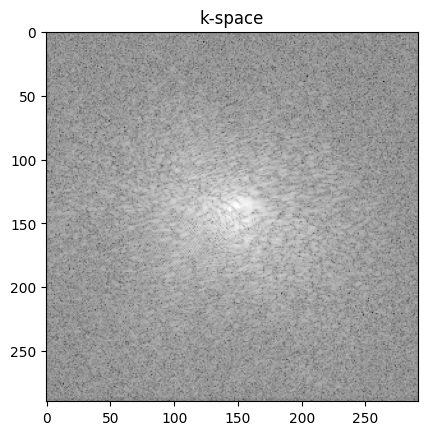

In [24]:
plt.imshow(np.log(np.abs(Kread[slice_idx, :, :, coil_idx])), cmap="gray")
plt.title("k-space")
plt.show()

#### Let's perform the inverse Fourier transform. We will use the `fftshift` and `ifftshift` methods to center the k-space data.

In [25]:
# orthogonal/centered IFFT
Imread = np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(Kread, axes=(0, 1, 2)), axes=(0, 1, 2)), axes=(0, 1, 2))

In [26]:
Imread = Imread / np.max(np.abs(Imread))

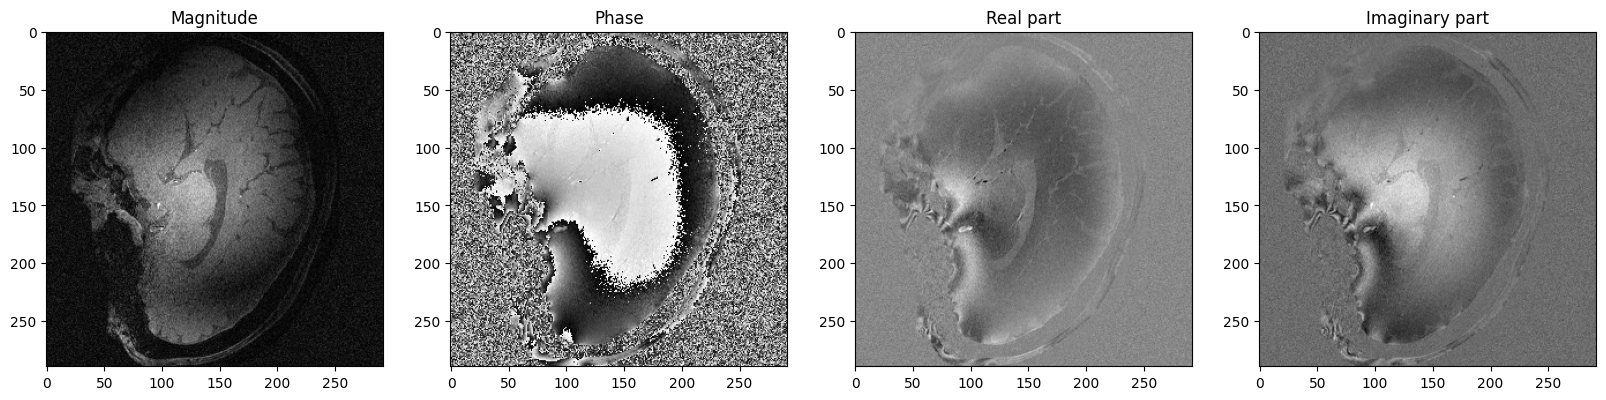

In [27]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(np.abs(Imread[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Magnitude")
plt.subplot(1, 4, 2)
plt.imshow(np.angle(Imread[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Phase")
plt.subplot(1, 4, 3)
plt.imshow(np.real(Imread[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Real part")
plt.subplot(1, 4, 4)
plt.imshow(np.imag(Imread[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Imaginary part")
plt.show()

#### Let's read the coil sensitivities. The coil sensitivities are stored in a separate file and NOT in raw format. We will use the `h5py` package to read the data. The coil sensitivities are stored in the `0real` and `1imag` datasets. We will read the data into a numpy array and then transpose the array to match the dimensions of the k-space data.

In [28]:
coil_sensitivities_filename = f"{dataset_path}/coilsens_001.h5"

In [22]:
import h5py

In [30]:
coil_sensitivities = h5py.File(coil_sensitivities_filename, "r")

In [31]:
coil_sensitivities.keys()

<KeysViewHDF5 ['0real', '1imag']>

In [32]:
coil_sensitivities_real = np.array(coil_sensitivities["0real"])
coil_sensitivities_imag = np.array(coil_sensitivities["1imag"])
coil_sensitivities = coil_sensitivities_real + 1j * coil_sensitivities_imag

In [33]:
coil_sensitivities.shape

(32, 292, 290, 234)

In [34]:
coil_sensitivities = np.transpose(coil_sensitivities, (3, 2, 1, 0))

In [35]:
coil_sensitivities.shape

(234, 290, 292, 32)

In [36]:
coil_sensitivities = coil_sensitivities / np.max(np.abs(coil_sensitivities))

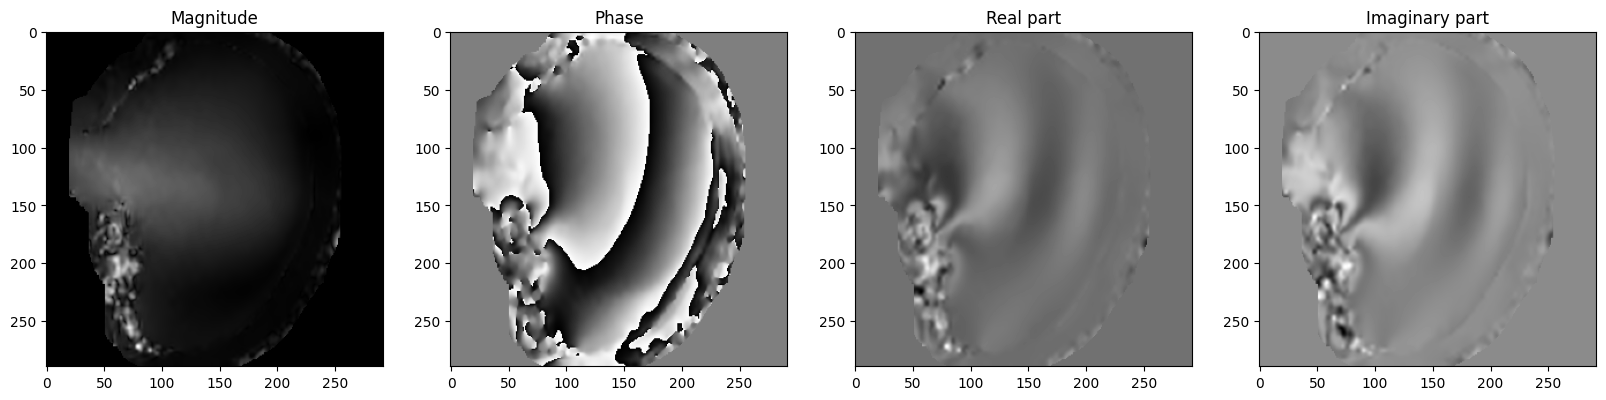

In [37]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(np.abs(coil_sensitivities[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Magnitude")
plt.subplot(1, 4, 2)
plt.imshow(np.angle(coil_sensitivities[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Phase")
plt.subplot(1, 4, 3)
plt.imshow(np.real(coil_sensitivities[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Real part")
plt.subplot(1, 4, 4)
plt.imshow(np.imag(coil_sensitivities[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Imaginary part")
plt.show()

#### Let's calculate the target image. We will use the SENSE reconstruction method to calculate the target image. The target image is the sum of the product of the k-space data and the complex conjugate of the coil sensitivities. We will then normalize the target image by the maximum value of the absolute value of the target image.

In [38]:
target = np.sum(Imread[slice_idx] * np.conj(coil_sensitivities[slice_idx]), axis=-1)

In [39]:
target.shape

(290, 292)

In [40]:
target = target / np.max(np.abs(target))

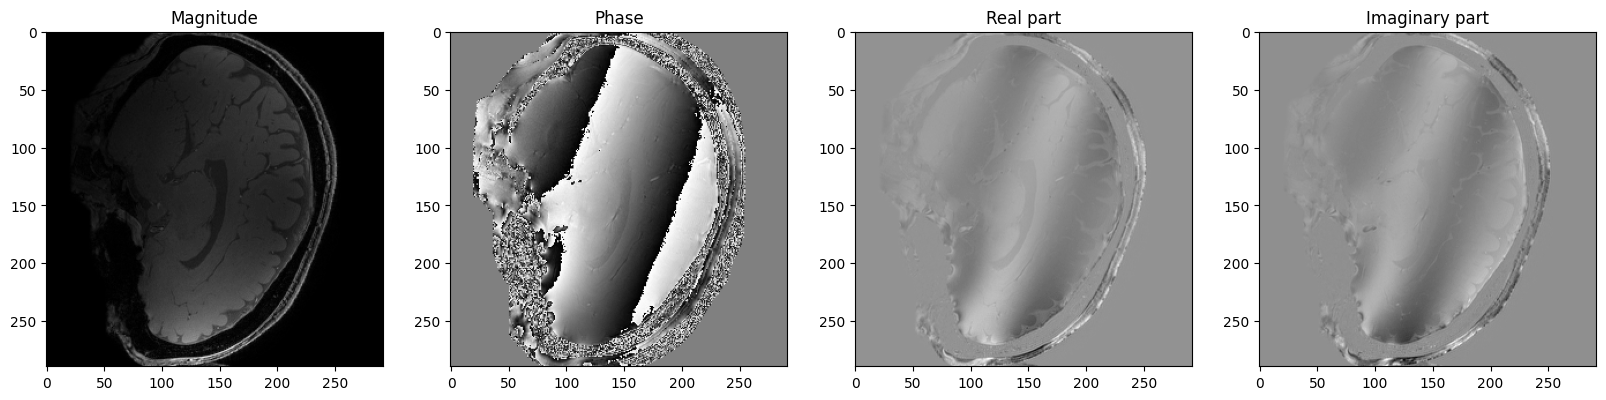

In [41]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(np.abs(target), cmap="gray")
plt.title("Magnitude")
plt.subplot(1, 4, 2)
plt.imshow(np.angle(target), cmap="gray")
plt.title("Phase")
plt.subplot(1, 4, 3)
plt.imshow(np.real(target), cmap="gray")
plt.title("Real part")
plt.subplot(1, 4, 4)
plt.imshow(np.imag(target), cmap="gray")
plt.title("Imaginary part")
plt.show()

#### We have now verified that the data look correct and we have find the correct transformations to preprocess our data. Let's now get another plane, the axial.

In [42]:
# get the axial plane
axial_Kread = np.transpose(Kread, (2, 0, 1, 3))

In [43]:
axial_Imread = np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(axial_Kread, axes=(0, 1, 2)), axes=(0, 1, 2)), axes=(0, 1, 2))

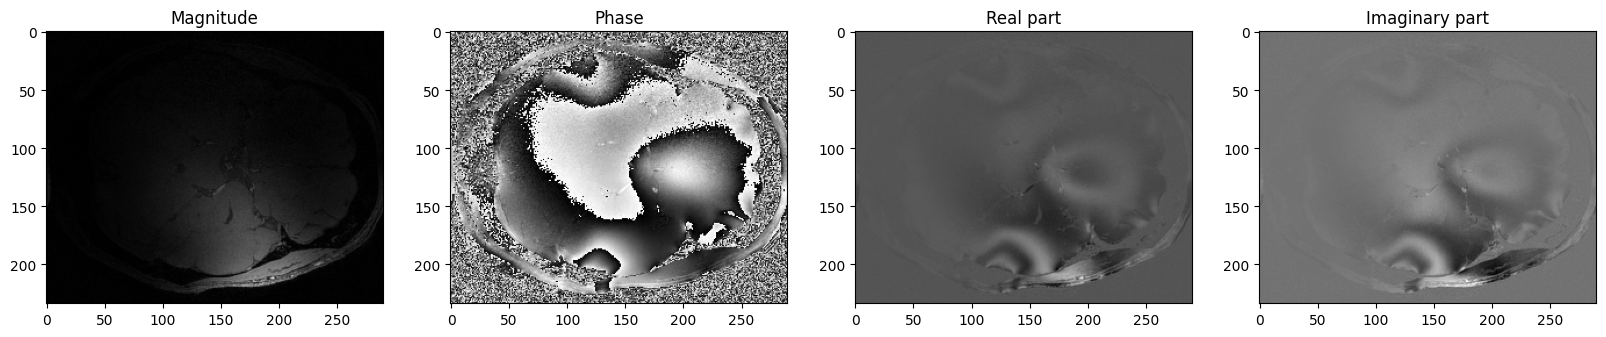

In [44]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(np.abs(axial_Imread[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Magnitude")
plt.subplot(1, 4, 2)
plt.imshow(np.angle(axial_Imread[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Phase")
plt.subplot(1, 4, 3)
plt.imshow(np.real(axial_Imread[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Real part")
plt.subplot(1, 4, 4)
plt.imshow(np.imag(axial_Imread[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Imaginary part")
plt.show()

### Let's transform our data to get the proper orientation.

In [45]:
axial_Imread = np.rot90(axial_Imread, k=1, axes=(1, 2))

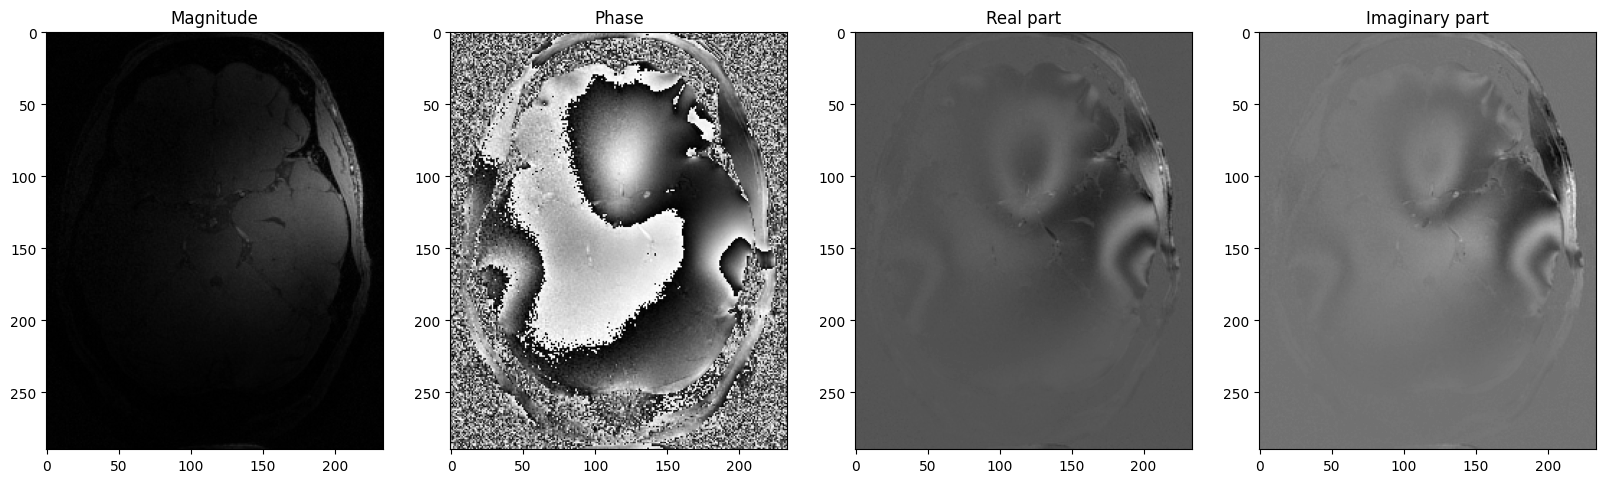

In [46]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(np.abs(axial_Imread[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Magnitude")
plt.subplot(1, 4, 2)
plt.imshow(np.angle(axial_Imread[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Phase")
plt.subplot(1, 4, 3)
plt.imshow(np.real(axial_Imread[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Real part")
plt.subplot(1, 4, 4)
plt.imshow(np.imag(axial_Imread[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Imaginary part")
plt.show()

In [47]:
# get axial coil sensitivities
axial_coil_sensitivities = np.fft.fftn(coil_sensitivities, axes=(0, 1, 2))
axial_coil_sensitivities = np.transpose(axial_coil_sensitivities, (2, 0, 1, 3))
axial_coil_sensitivities = np.fft.ifftn(axial_coil_sensitivities, axes=(0, 1, 2))

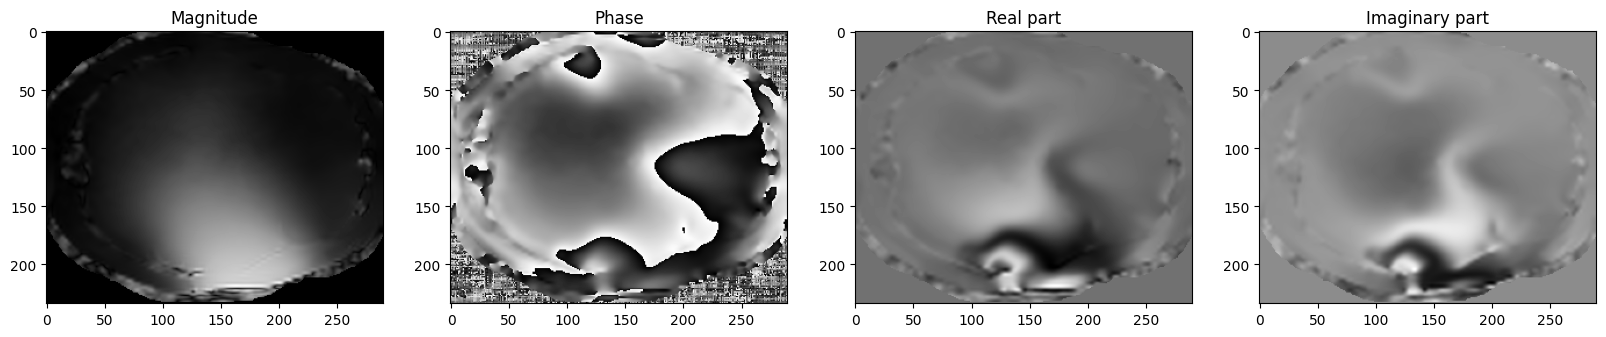

In [48]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(np.abs(axial_coil_sensitivities[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Magnitude")
plt.subplot(1, 4, 2)
plt.imshow(np.angle(axial_coil_sensitivities[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Phase")
plt.subplot(1, 4, 3)
plt.imshow(np.real(axial_coil_sensitivities[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Real part")
plt.subplot(1, 4, 4)
plt.imshow(np.imag(axial_coil_sensitivities[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Imaginary part")
plt.show()

### Let's transform our data to get the proper orientation.

In [49]:
axial_coil_sensitivities = np.rot90(axial_coil_sensitivities, k=1, axes=(1, 2))

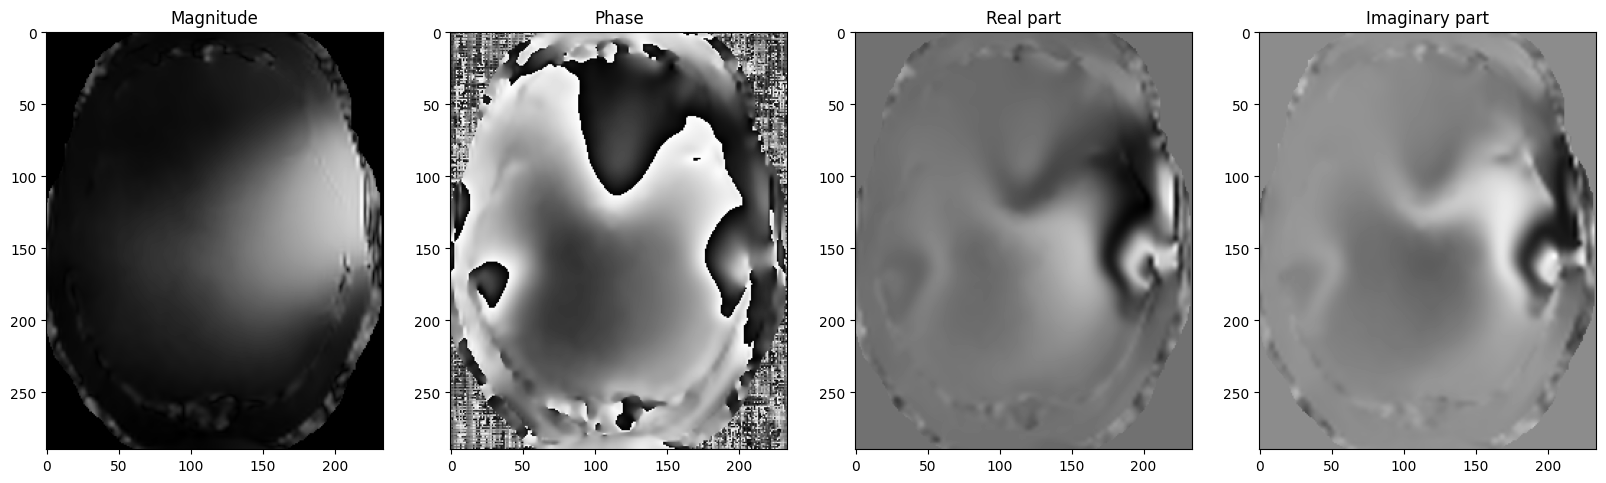

In [50]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(np.abs(axial_coil_sensitivities[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Magnitude")
plt.subplot(1, 4, 2)
plt.imshow(np.angle(axial_coil_sensitivities[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Phase")
plt.subplot(1, 4, 3)
plt.imshow(np.real(axial_coil_sensitivities[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Real part")
plt.subplot(1, 4, 4)
plt.imshow(np.imag(axial_coil_sensitivities[slice_idx, :, :, coil_idx]), cmap="gray")
plt.title("Imaginary part")
plt.show()

In [51]:
# get the axial target
axial_target = np.sum(axial_Imread[slice_idx] * np.conj(axial_coil_sensitivities[slice_idx]), axis=-1)

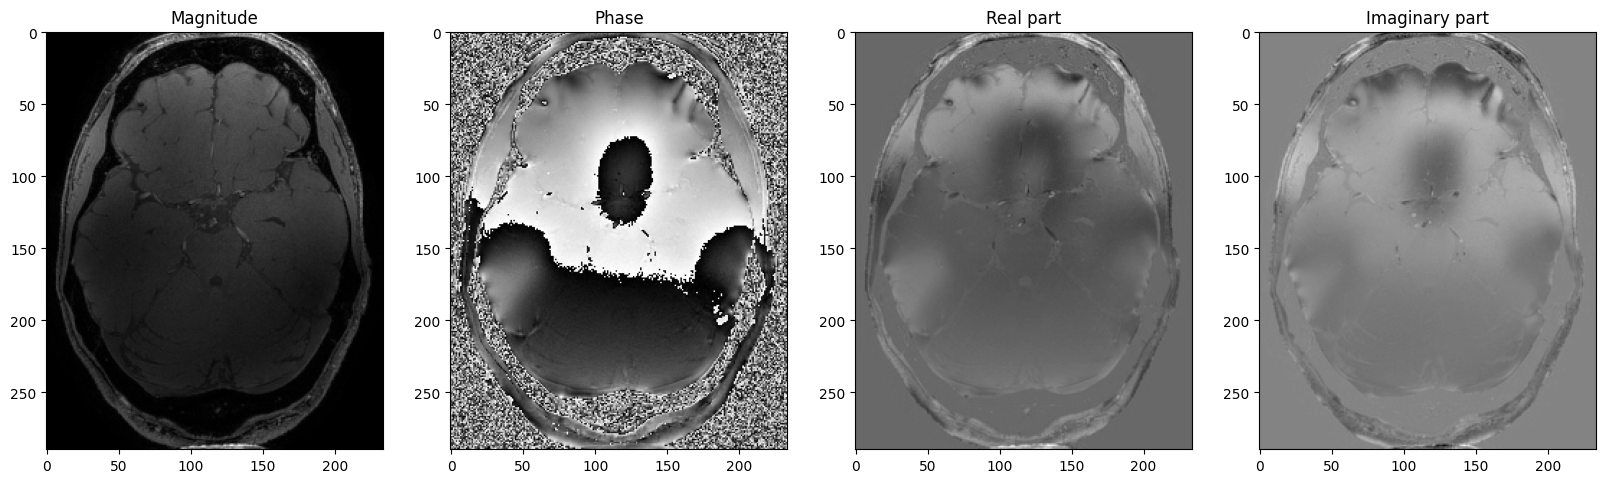

In [52]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(np.abs(axial_target), cmap="gray")
plt.title("Magnitude")
plt.subplot(1, 4, 2)
plt.imshow(np.angle(axial_target), cmap="gray")
plt.title("Phase")
plt.subplot(1, 4, 3)
plt.imshow(np.real(axial_target), cmap="gray")
plt.title("Real part")
plt.subplot(1, 4, 4)
plt.imshow(np.imag(axial_target), cmap="gray")
plt.title("Imaginary part")
plt.show()

#### We verified that we can get the axial images properly as well. Let's get going and estimate parameter maps.

##### First we need to calculate the brain mask. We will use the axial images for this. We will use the Otsu thresholding method to estimate the brain mask. We will then dilate the brain mask to get a better estimate of the brain mask. We will then get the convex hull of the brain mask to get a better estimate of the brain mask.

In [7]:
from skimage.filters import threshold_otsu
from scipy.ndimage import binary_dilation
from skimage.morphology import convex_hull_image

In [54]:
# compute brain mask
brain_mask = np.abs(axial_target) > threshold_otsu(np.abs(axial_target))
brain_mask = np.array(brain_mask, dtype=np.float32)
brain_mask = binary_dilation(brain_mask, iterations=4)
# get the convex hull of the brain mask
brain_mask = convex_hull_image(brain_mask)
brain_mask = 1 - brain_mask

In [55]:
brain_mask.shape

(290, 234)

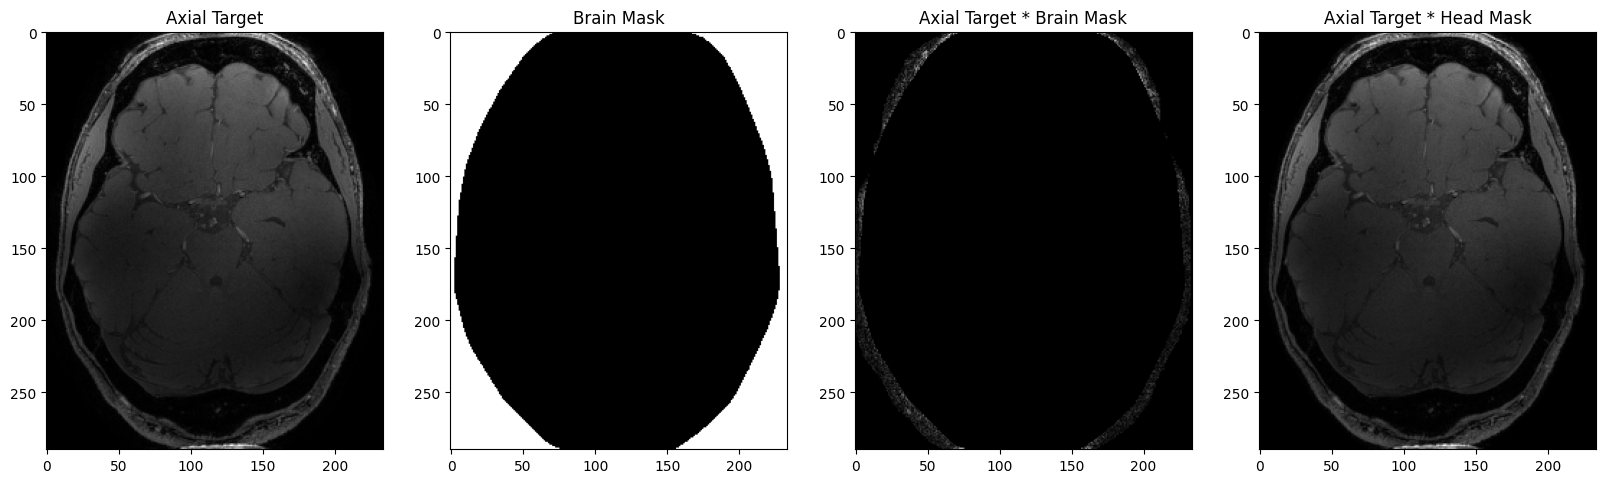

In [56]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(np.abs(axial_target), cmap="gray")
plt.title("Axial Target")
plt.subplot(1, 4, 2)
plt.imshow(brain_mask, cmap="gray")
plt.title("Brain Mask")
plt.subplot(1, 4, 3)
plt.imshow(np.abs(axial_target) * brain_mask, cmap="gray")
plt.title("Axial Target * Brain Mask")
plt.subplot(1, 4, 4)
plt.imshow(np.abs(axial_target) * (1 - brain_mask), cmap="gray")
plt.title("Axial Target * Head Mask")
plt.show()

##### Now we will estimate quantitative maps. We will estimate R2*, S0, B0, and phi maps. But first we need to apply the brain mask to the images and unwrap the phase.

In [57]:
coilimgs = axial_Imread[slice_idx] * np.repeat(brain_mask[..., np.newaxis], axial_Imread.shape[-1], axis=-1)
sense = axial_coil_sensitivities[slice_idx] * np.repeat(brain_mask[..., np.newaxis], axial_coil_sensitivities.shape[-1], axis=-1)

In [8]:
from skimage.restoration import unwrap_phase

In [59]:
phases = np.angle(np.sum(coilimgs * sense.conj(), -1))
phase_unwrapped = unwrap_phase(np.ma.array(phases, mask=np.zeros(phases.shape)))

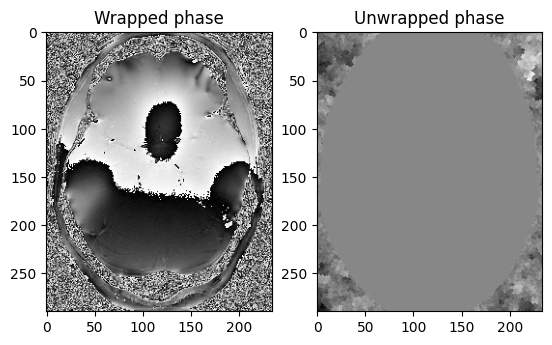

In [60]:
plt.subplot(1, 2, 1)
plt.imshow(np.angle(axial_target), cmap="gray")
plt.title("Wrapped phase")
plt.subplot(1, 2, 2)
plt.imshow(phase_unwrapped, cmap="gray")
plt.title("Unwrapped phase")
plt.show()

#### We can now start estimating the quantitative maps (R2*, B0, S0, and phi), using the mridc library. The given echo times are TEs = [3.0, 11.5, 20.0, 28.5].

Note: For proper estimation of the quantitative maps, we need to load all the four (k-space) echo times. But to begin with we will create a dummy "4-echoed" input, by repeating the first echo four times. This is just to verify that the code works. We will then use the actual data to estimate the quantitative maps.

In [9]:
import torch
from mridc.collections.quantitative.parts.transforms import R2star_mapping, B0_phi_mapping, S0_mapping

/scratch/dkarkalousos/envs/mridc/lib/python3.10/site-packages/wandb/env.py:16: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.util import strtobool
[MRIDC W 2023-02-14 23:59:06 mridc_logging:334] <frozen importlib._bootstrap_external>:572: DeprecationWarning: find_module() is deprecated and slated for removal in Python 3.12; use find_spec() instead
    
[MRIDC W 2023-02-14 23:59:06 mridc_logging:334] <frozen importlib._bootstrap_external>:1514: DeprecationWarning: FileFinder.find_loader() is deprecated and slated for removal in Python 3.12; use find_spec() instead
    
[Hydra plugins scanner] : warnings from 'hydra._internal.core_plugins.bash_completion'. Please report to plugin author.
[MRIDC W 2023-02-14 23:59:06 mridc_logging:334] <frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12;

In [62]:
axial_target_tensor = np.stack([np.real(axial_target), np.imag(axial_target)], axis=-1)
axial_target_tensor = torch.from_numpy(axial_target_tensor)
axial_target_tensor = torch.view_as_complex(axial_target_tensor)
axial_target_tensor = torch.view_as_real(axial_target_tensor)

In [63]:
prediction = axial_target_tensor.unsqueeze(0)  # then add a dummy echo dimension
prediction = torch.cat([prediction, prediction, prediction, prediction], dim=0)  # add dummy four echo times
TEs = [3.0, 11.5, 20.0, 28.5]  # four echo times

In [64]:
R2star_map = R2star_mapping(prediction, TEs)

In [65]:
R2star_map.shape

torch.Size([290, 234])

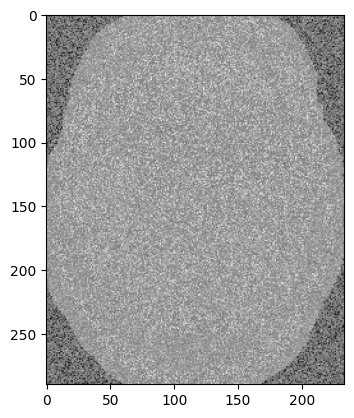

In [66]:
plt.imshow(R2star_map, cmap="gray")
plt.show()

In [67]:
mask_brain = torch.from_numpy(brain_mask)
mask_brain = mask_brain.unsqueeze(0)
head_mask = 1 - mask_brain
fully_sampled = True
shift = False
fft_centered = False
fft_normalization = "backward"
spatial_dims = [-2, -1]

In [68]:
B0_map = -B0_phi_mapping(
    prediction,
    TEs,
    mask_brain,
    head_mask,
    fully_sampled,
    shift=shift,
    fft_centered=fft_centered,
    fft_normalization=fft_normalization,
    spatial_dims=spatial_dims,
)[0]

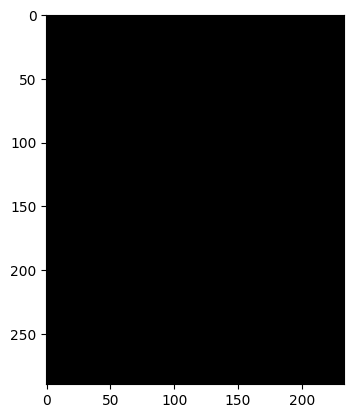

In [69]:
plt.imshow(B0_map[0], cmap="gray")
plt.show()

In [70]:
S0_map_real, S0_map_imag = S0_mapping(
    prediction,
    TEs,
    R2star_map,
    B0_map,
    shift=shift,
    fft_centered=fft_centered,
    fft_normalization=fft_normalization,
    spatial_dims=spatial_dims,
)

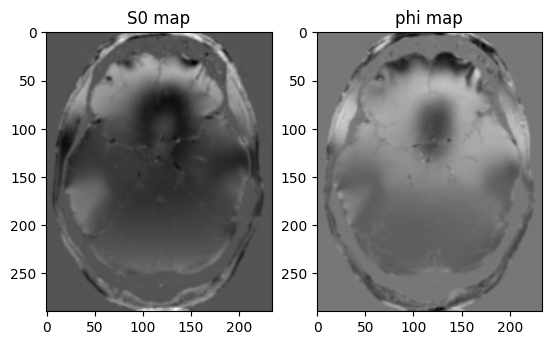

In [71]:
plt.subplot(1, 2, 1)
plt.imshow(S0_map_real, cmap="gray")
plt.title("S0 map")
plt.subplot(1, 2, 2)
plt.imshow(S0_map_imag, cmap="gray")
plt.title("phi map")
plt.show()

# Great! Or almost great. The quantitative maps of course do not look correct, since we did not use the proper echo times. So, let's go on to estimate proper quantitative maps, using the actual (four echo times of the second inversion) data.

#### Let's wrap up everything and create our preprocessing function for the AHEAD dataset.

Note: In total we have one echo time for the 1st inversion and four echo times for the 2nd inversion. So we will have 5 echo times in total.

In [10]:
from pathlib import Path
from typing import Tuple, List

In [11]:
def __preprocess_ahead_raw_data__(raw_data_file: str) -> np.ndarray:
    """
    Preprocess the raw data of the AHEAD dataset.

    Parameters
    ----------
    raw_data_file : str
        Path to the raw data and coil sensitivities of the AHEAD dataset.

    Returns
    -------
    kspace: np.ndarray
        The k-space data.
    """
    dataset = ismrmrd.Dataset(raw_data_file, "dataset", create_if_needed=False)
    number_of_acquisitions = dataset.number_of_acquisitions()

    # find the first no noise scan
    first_scan = 0
    for i in tqdm(range(number_of_acquisitions)):
        head = dataset.read_acquisition(i).getHead()
        if head.isFlagSet(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
            first_scan = i
            break

    meas = []
    for i in tqdm(range(first_scan, number_of_acquisitions)):
        acq = dataset.read_acquisition(i)
        meas.append(acq)

    hdr = ismrmrd.xsd.CreateFromDocument(dataset.read_xml_header())

    # Matrix size
    enc = hdr.encoding[0]
    enc_Nx = enc.encodedSpace.matrixSize.x
    enc_Ny = enc.encodedSpace.matrixSize.y
    enc_Nz = enc.encodedSpace.matrixSize.z

    nCoils = hdr.acquisitionSystemInformation.receiverChannels

    nslices = enc.encodingLimits.slice.maximum + 1 if enc.encodingLimits.slice is not None else 1
    nreps = enc.encodingLimits.repetition.maximum + 1 if enc.encodingLimits.repetition is not None else 1
    ncontrasts = enc.encodingLimits.contrast.maximum + 1 if enc.encodingLimits.contrast is not None else 1

    # initialize k-space array
    Kread = np.zeros((enc_Nx, enc_Ny, enc_Nz, nCoils), dtype=np.complex64)

    # Select the appropriate measurements from the data
    for acq in tqdm(meas):
        head = acq.getHead()
        if head.idx.contrast == ncontrasts - 1 and head.idx.repetition == nreps - 1 and head.idx.slice == nslices - 1:
            head = acq.getHead()
            ky = head.idx.kspace_encode_step_1
            kz = head.idx.kspace_encode_step_2
            Kread[:, ky, kz, :] = np.transpose(acq.data, (1, 0))

    return Kread

#### Let's test our preprocessing function. This will take a while.

In [12]:
# get all files
files = list(Path(dataset_path).iterdir())
# get the fnames
fnames = [str(file).split('/')[-1].split('_')[1].split('.')[0] for file in files if "coilsens" in file.name]

In [13]:
# let's do the first subject in our list
fname = fnames[0]
print(f"Processing subject {fname}...")

Processing subject 001...


In [14]:
# get all files for this subject from files
subject_files = [file for file in files if fname in file.name]
raw_data_files = [file for file in subject_files if "coilsens" not in file.name and "inv1" not in file.name]
raw_data_files.sort()

In [15]:
# preprocess the raw data
kspaces = [__preprocess_ahead_raw_data__(str(x)) for x in raw_data_files]

100%|██████████| 84680/84680 [00:07<00:00, 11102.45it/s]


In [16]:
print(f"Number of kspaces: {len(kspaces)}")

Number of kspaces: 4


#### Let's wrap up a function to get different planes from the data.

In [17]:
def __get_plane__(data: np.ndarray, data_on_kspace: bool = True, plane: str = "sagittal") -> np.ndarray:
    """
    Get the given plane from the data.

    Parameters
    ----------
    data : np.ndarray
        The data to get the plane from.
    data_on_kspace : bool, optional
        Whether the data is on the kspace or not. The default is True.
    plane : str, optional
        The plane to get the kspace and coil sensitivities from. The default is "sagittal".

    Returns
    -------
    data: np.ndarray
        The data of the given plane.
    """
    if not data_on_kspace:
        data = np.fft.fftn(data, axes=(0, 1, 2))

    if plane == "axial":
        data = np.transpose(data, (2, 0, 1, 3))
    elif plane == "coronal":
        data = np.transpose(data, (1, 0, 2, 3))

    # all planes need to be rotated by 90 degrees in x-y to get the correct orientation
    data = np.rot90(data, k=1, axes=(1, 2))

    if not data_on_kspace:
        data = np.fft.ifftn(data, axes=(0, 1, 2))

    return data

In [18]:
axial_kspaces = [__get_plane__(x, data_on_kspace=True, plane="axial") for x in kspaces]

### Do the same for the coil sensitivities

In [19]:
def __preprocess_ahead_coil_sensitivities__(coil_sensitivities_file: str) -> np.ndarray:
    """
    Preprocess the coil sensitivities of the AHEAD dataset.

    Parameters
    ----------
    coil_sensitivities_file : str
        Path to the coil sensitivities of the AHEAD dataset.

    Returns
    -------
    coil_sensitivities: np.ndarray
        The coil sensitivities.
    """
    # load the coil sensitivities
    coil_sensitivities = h5py.File(coil_sensitivities_file, "r")

    # get the coil sensitivities
    coil_sensitivities_real = np.array(coil_sensitivities["0real"])
    coil_sensitivities_imag = np.array(coil_sensitivities["1imag"])
    coil_sensitivities = coil_sensitivities_real + 1j * coil_sensitivities_imag

    # transpose to get the correct shape, i.e. (x, y, z, coils)
    coil_sensitivities = np.transpose(coil_sensitivities, (3, 2, 1, 0))

    return coil_sensitivities

In [20]:
coil_sensitivities_file = [file for file in subject_files if "coilsens" in file.name][0]

In [23]:
coil_sensitivities = __preprocess_ahead_coil_sensitivities__(str(coil_sensitivities_file))

In [24]:
axial_coil_sensitivities = __get_plane__(coil_sensitivities, data_on_kspace=False, plane="axial")

#### Let's wrap up a function that transforms the kspaces to image space and computes target images.

In [25]:
def __compute_targets__(
        kspace: np.ndarray, coil_sensitivities: np.ndarray, coil_dim: int = -1
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the target images from the kspace and coil sensitivities.

    Parameters
    ----------
    kspace : np.ndarray
        The kspace.
    coil_sensitivities : np.ndarray
        The coil sensitivities.
    coil_dim : int, optional
        The dimension of the coil sensitivities. The default is -1.

    Returns
    -------
    image_space : np.ndarray
        The image space.
    target_image : np.ndarray
        The target image.
    """
    # get the image space
    image_space = np.fft.fftshift(
        np.fft.ifftn(np.fft.fftshift(kspace, axes=(0, 1, 2)), axes=(0, 1, 2)), axes=(0, 1, 2)
    )

    # compute the target
    target = np.sum(image_space * np.conj(coil_sensitivities), axis=coil_dim)

    return image_space, target

In [26]:
# compute the image spaces and targets
axial_image_spaces = []
axial_targets = []
for x in axial_kspaces:
    axial_image_space, axial_target = __compute_targets__(x, axial_coil_sensitivities, coil_dim=-1)
    axial_image_spaces.append(axial_image_space)
    axial_targets.append(axial_target)
axial_image_space = np.stack(axial_image_spaces, axis=1)
axial_target = np.stack(axial_targets, axis=1)

#### Let's visualize the target images of 2nd inversion for the four echo times.

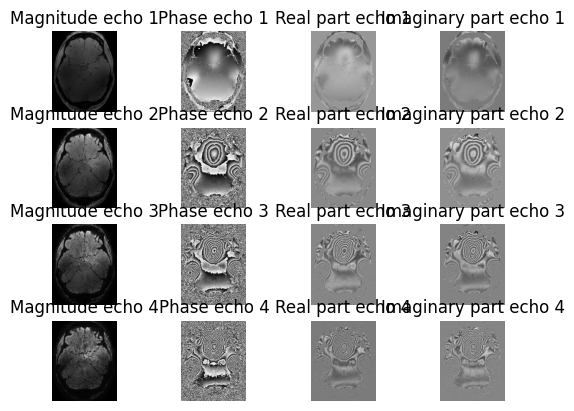

In [29]:
plt.subplot(4, 4, 1)
plt.imshow(np.abs(axial_target[slice_idx, 0, :, :]), cmap="gray")
plt.title("Magnitude echo 1")
plt.axis("off")
plt.subplot(4, 4, 2)
plt.imshow(np.angle(axial_target[slice_idx, 0, :, :]), cmap="gray")
plt.title("Phase echo 1")
plt.axis("off")
plt.subplot(4, 4, 3)
plt.imshow(np.real(axial_target[slice_idx, 0, :, :]), cmap="gray")
plt.title("Real part echo 1")
plt.axis("off")
plt.subplot(4, 4, 4)
plt.imshow(np.imag(axial_target[slice_idx, 0, :, :]), cmap="gray")
plt.title("Imaginary part echo 1")
plt.axis("off")
plt.subplot(4, 4, 5)
plt.imshow(np.abs(axial_target[slice_idx, 1, :, :]), cmap="gray")
plt.title("Magnitude echo 2")
plt.axis("off")
plt.subplot(4, 4, 6)
plt.imshow(np.angle(axial_target[slice_idx, 1, :, :]), cmap="gray")
plt.title("Phase echo 2")
plt.axis("off")
plt.subplot(4, 4, 7)
plt.imshow(np.real(axial_target[slice_idx, 1, :, :]), cmap="gray")
plt.title("Real part echo 2")
plt.axis("off")
plt.subplot(4, 4, 8)
plt.imshow(np.imag(axial_target[slice_idx, 1, :, :]), cmap="gray")
plt.title("Imaginary part echo 2")
plt.axis("off")
plt.subplot(4, 4, 9)
plt.imshow(np.abs(axial_target[slice_idx, 2, :, :]), cmap="gray")
plt.title("Magnitude echo 3")
plt.axis("off")
plt.subplot(4, 4, 10)
plt.imshow(np.angle(axial_target[slice_idx, 2, :, :]), cmap="gray")
plt.title("Phase echo 3")
plt.axis("off")
plt.subplot(4, 4, 11)
plt.imshow(np.real(axial_target[slice_idx, 2, :, :]), cmap="gray")
plt.title("Real part echo 3")
plt.axis("off")
plt.subplot(4, 4, 12)
plt.imshow(np.imag(axial_target[slice_idx, 2, :, :]), cmap="gray")
plt.title("Imaginary part echo 3")
plt.axis("off")
plt.subplot(4, 4, 13)
plt.imshow(np.abs(axial_target[slice_idx, 3, :, :]), cmap="gray")
plt.title("Magnitude echo 4")
plt.axis("off")
plt.subplot(4, 4, 14)
plt.imshow(np.angle(axial_target[slice_idx, 3, :, :]), cmap="gray")
plt.title("Phase echo 4")
plt.axis("off")
plt.subplot(4, 4, 15)
plt.imshow(np.real(axial_target[slice_idx, 3, :, :]), cmap="gray")
plt.title("Real part echo 4")
plt.axis("off")
plt.subplot(4, 4, 16)
plt.imshow(np.imag(axial_target[slice_idx, 3, :, :]), cmap="gray")
plt.title("Imaginary part echo 4")
plt.axis("off")
plt.show()

#### Alright, now we have our kspaces and coil sensitivities in the axial plane for all four echo times for one subject. Let's finish with our preprocessing transforms by wrapping up a function that computes brain and head masks. Note that the brain and head masks are the same for all echo times, thus we can compute them only for one and use them for all. Then we are done with the preprocessing.

In [30]:
def __compute_masks__(target_image: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the brain and head masks.

    Parameters
    ----------
    target_image : np.ndarray
        The target image.
    Returns
    -------
    brain_mask : np.ndarray
        The brain mask.
    head_mask : np.ndarray
        The head mask.
    """
    # compute head and brain mask
    head_masks = []
    brain_masks = []
    for _slice_idx_ in tqdm(range(target_image.shape[0])):
        # get the head mask
        head_mask = np.abs(target_image[_slice_idx_]) > threshold_otsu(np.abs(target_image[_slice_idx_]))
        # dilate the head mask
        head_mask = binary_dilation(head_mask, iterations=4)
        # get the convex hull of the head mask
        head_mask = convex_hull_image(head_mask)  # type: ignore
        head_masks.append(head_mask)
        brain_masks.append(1 - head_mask)
    head_mask = np.stack(head_masks, axis=0)
    brain_mask = np.stack(brain_masks, axis=0)
    return brain_mask.astype(np.float32), head_mask.astype(np.float32)

In [31]:
# the brain and head masks are the same for all echoes
brain_mask, head_mask = __compute_masks__(axial_target[:, 0, :, :])

100%|██████████| 292/292 [00:10<00:00, 29.14it/s]


#### Let's visualize the masks

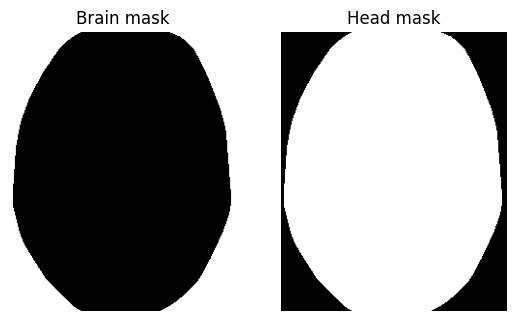

In [32]:
plt.subplot(1, 2, 1)
plt.imshow(brain_mask[slice_idx], cmap="gray")
plt.title("Brain mask")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(head_mask[slice_idx], cmap="gray")
plt.title("Head mask")
plt.axis("off")
plt.show()

#### We are done with the preprocessing! Let's go on and compute proper quantitative maps from the four echo times.

We will use the mridc package for this. The `R2star_B0_real_S0_complex_mapping' will allow us to compute the R2*, B0, S0, and phi maps.

We only need to convert our target images to torch tensors and pass them to the mapping function with the corresponding echo times.

In [33]:
from mridc.collections.quantitative.parts.transforms import R2star_B0_real_S0_mapping

In [34]:
def __compute_quantitative_maps__(
        target_images: np.ndarray,
        TEs: List[float],
        brain_mask: np.ndarray,
        head_mask: np.ndarray,
        fully_sampled: bool = True,
        shift: bool = False,
        fft_centered: bool = False,
        fft_normalization: str = "backward",
        spatial_dims=None,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute the quantitative maps.

    Parameters
    ----------
    target_images : np.ndarray
        The target images.
    TEs : List[float]
        The echo times.
    brain_mask : np.ndarray
        The brain mask.
    head_mask : np.ndarray
        The head mask.
    fully_sampled : bool, optional
        Whether the data is fully sampled or not. The default is True.
    shift : bool, optional
        Whether to shift the kspace or not. The default is False.
    fft_centered : bool, optional
        Whether the fft is centered or not. The default is False.
    fft_normalization : str, optional
        The fft normalization. The default is "backward".
    spatial_dims : List[int], optional
        The spatial dimensions. The default is [-2, -1].

    Returns
    -------
    multiple_echoes_target : np.ndarray
        The stacked target image from multiple echoes.
    R2star_map : np.ndarray
        The R2* map.
    S0_map : np.ndarray
        The S0 map.
    B0_map : np.ndarray
        The B0 map.
    phi_map : np.ndarray
        The phase map.
    """
    # stack real and imaginary part of the target image
    if spatial_dims is None:
        spatial_dims = [-2, -1]
    multiple_echoes_target_tensor = np.stack([np.real(target_images), np.imag(target_images)], axis=-1)
    # convert to torch tensor
    multiple_echoes_target_tensor = torch.from_numpy(multiple_echoes_target_tensor)
    # verify the tensor will be complex valued
    multiple_echoes_target_tensor = torch.view_as_complex(multiple_echoes_target_tensor)
    # verify the tensor can be converted to real valued, with stacked real and imag parts on the last dimension
    multiple_echoes_target_tensor = torch.view_as_real(multiple_echoes_target_tensor)

    brain_mask = torch.from_numpy(brain_mask).unsqueeze(1)
    head_mask = torch.from_numpy(head_mask).unsqueeze(1)

    R2star_maps = []
    S0_maps = []
    B0_maps = []
    phi_maps = []
    for slice_idx in tqdm(range(multiple_echoes_target_tensor.shape[0])):
        # compute the quantitative maps
        R2star_map, S0_map, B0_map, phi_map = R2star_B0_real_S0_complex_mapping(
            prediction=multiple_echoes_target_tensor[slice_idx],
            TEs=TEs,
            brain_mask=brain_mask[slice_idx],
            head_mask=head_mask[slice_idx],
            fully_sampled=fully_sampled,
            shift=shift,
            fft_centered=fft_centered,
            fft_normalization=fft_normalization,
            spatial_dims=spatial_dims
        )
        R2star_maps.append(R2star_map)
        S0_maps.append(S0_map)
        B0_maps.append(B0_map[0])
        phi_maps.append(phi_map)

    R2star_maps = torch.stack(R2star_maps, dim=0).numpy()
    S0_maps = torch.stack(S0_maps, dim=0).numpy()
    B0_maps = torch.stack(B0_maps, dim=0).numpy()
    phi_maps = torch.stack(phi_maps, dim=0).numpy()

    return torch.view_as_complex(multiple_echoes_target_tensor).numpy(), R2star_maps, S0_maps, B0_maps, phi_maps

In [35]:
# just for reminder, those are the TEs of the dataset
TEs = [3.0, 11.5, 20.0, 28.5]

In [36]:
# we will do 1 slice for ease of this example
multiple_echoes_target_tensor, R2star_map, S0_map, B0_map, phi_map = __compute_quantitative_maps__(
    axial_target[slice_idx:slice_idx+1],
    TEs,
    brain_mask[slice_idx:slice_idx+1],
    head_mask[slice_idx:slice_idx+1],
    fully_sampled=True,
    shift=False,
    fft_centered=False,
    fft_normalization="backward",
    spatial_dims=[-2, -1]
)

  0%|          | 0/1 [00:00<?, ?it/s]


RuntimeError: expected scalar type Float but found Double

In [ ]:
print(
    f"Shape of the target tensor: {multiple_echoes_target_tensor.shape}\n"
    f"Shape of the R2* map: {R2star_map.shape}\n"
    f"Shape of the S0 map: {S0_map.shape}\n"
    f"Shape of the B0 map: {B0_map.shape}\n"
    f"Shape of the phi map: {phi_map.shape}\n"
)

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(R2star_map[0], cmap="gray")
plt.title("R2*")
plt.axis("off")
plt.subplot(1, 4, 2)
plt.imshow(S0_map[0], cmap="gray")
plt.title("S0")
plt.axis("off")
plt.subplot(1, 4, 3)
plt.imshow(B0_map[0], cmap="gray")
plt.title("B0")
plt.axis("off")
plt.subplot(1, 4, 4)
plt.imshow(phi_map[0], cmap="gray")
plt.title("Phi")
plt.axis("off")
plt.show()

### Awesome! We have computed the R2*, B0, S0, and phi maps from the four echo times!

### Conclusion

In this notebook, we have shown how to preprocess the AHEAD dataset and compute the R2*, B0, S0, and phi maps from data with multiple echo times.

You can now download the AHEAD dataset and use the preprocessing script to batch process multiple subjects and save the inputs to disk. You can then use the preprocessed data to train a Deep Learning quantitative model by configuring the `data` section of the `config.yaml` file.

Enjoy!

## References

Caan, Matthan, 2022, "Quantitative motion-corrected 7T sub-millimeter raw MRI database of the adult lifespan", https://doi.org/10.34894/IHZGQM, DataverseNL, V1